# DATA605 Final Project                                                                      
### Ling Cai


## About This File: 

###### This project is to study the factors in the college admission / enrollment process. This Jupyter notebook is used for data cleaning and calculation, with limited but necessary visualization. The cleaned data is used by Tableau for subsequet visualization (no data calculation in Tableau). For the final product, please refer to Tableau. This Jupyter notebook is just a suppliment material if you want to see some background information.

In [87]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [88]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## 1. Set up the Data Frame

In [89]:
# Import the first file. This is the main file. 

xls_file1 = pd.ExcelFile('ipeds original.xlsx')
df_ipeds_original = xls_file1.parse('Smaller file')
# df_ipeds_original = pd.read_excel('ipeds.xlsx', sheetname = 'Smaller file') # Alternatively you can use this line.
# df_ipeds_original.head(1) 

# Drop some un-necessary columns
df_ipeds_temp = df_ipeds_original.drop([ 'year','Calculated SAT CR Mean', 'Calculated SAT M Mean', 'Estimated enrollment, total', 'Estimated undergraduate enrollment, total', 'Estimated first-time degree/certificate-seeking undergraduate enrollment, total', 'Estimated graduate enrollment, total', 'Admissions yield  (percent of admitted freshmen enrolling)'
], axis=1)

# The regular .head() code does not display all the columns. Therefore use the line below. 
# for col in df_ipeds_temp.columns:
#     print(col)
#     print(col + ": " + str(df_ipeds_original[col].dtype)) # Do this if you want to see the data type. 

In [90]:
# Import the second file. This file contains the graduation rate variable. 

xls_file2 = pd.ExcelFile('CompletionRate.xlsx')
df_grad_ori = xls_file2.parse('Sheet1')
df_grad_ori.dropna(subset=['C150_4'], inplace = True)
df_grad_ori.drop([ 'OPEID','OPEID6','INSTNM'], axis = 1, inplace = True) 
df_grad_ori.rename(index=str, columns={'UNITID': 'unitid'}, inplace =True)
df_grad_ori.rename(index=str, columns={'C150_4': 'grad_rate'}, inplace =True)
# df_grad_ori.head(1)

In [91]:
# In the first file, remove any rows that have null values in the SAT/ACT columns
df_ipeds_temp.dropna(subset=['Calculated SAT M+CR Mean', 'Calculated ACT C Mean', 'Applicants total', 'Admissions total', 
                             'Enrolled total'], inplace = True)

# Create some columns based on calculation

# Normalize the SAT score by dividing 1600 (total possible score)
df_ipeds_temp['Normalized_SAT'] = df_ipeds_temp['Calculated SAT M+CR Mean'] /1600
# Normalize the ACT score by dividing 36 (total possible score)
df_ipeds_temp['Normalized_ACT'] = df_ipeds_temp['Calculated ACT C Mean'] /36
# Get average for the two normalized test score
df_ipeds_temp['Normalized_SAT_ACT']= df_ipeds_temp[['Normalized_SAT','Normalized_ACT']].mean(axis=1)
# Admission_pct, a.k.a. Offer Rate, is to measure the % of applicants who received the offer 
df_ipeds_temp['Admission_pct']= df_ipeds_temp['Admissions total'] / df_ipeds_temp['Applicants total']
# Enroll_pct is to measure the % of offer receiver who eventually enrolled
df_ipeds_temp['Enroll_pct']= df_ipeds_temp['Enrolled total'] / df_ipeds_temp['Admissions total']
# 'Desire' is to measure the ratio of Enroll_pct / Admission_pct
df_ipeds_temp['Desire']= df_ipeds_temp['Enroll_pct'] / df_ipeds_temp['Admission_pct']
# 'Chosen_pct' is to measure the % of who enrolled against applicants. a.k.a. Of total applicants, the % that enrolled. 
df_ipeds_temp['Chosen_pct']= df_ipeds_temp['Enrolled total'] / df_ipeds_temp['Applicants total']
# 'POT_applied' is to measure that of total students(who enrolled in U.S. colleges), the % of them applied a specific college
df_ipeds_temp['POT_applied']= df_ipeds_temp['Applicants total'].div(df_ipeds_temp['Enrolled total'].sum())
# create a new column Tuition_Revised base on Private/Public. This variable is used in some part of the analysis. 
# If 'Public' then Tuition = In State Tuition. Else (will be 'private') then = Out State Tuition
df_ipeds_temp['Tuition_Revised'] = np.where(df_ipeds_temp['Control_of_institution']=='Public', df_ipeds_temp['Tuition_In_State'], df_ipeds_temp['Tuition_Out_State'])
# drop un-necessary columns
df_ipeds_temp.drop([ 'Normalized_SAT','Normalized_ACT'], axis = 1) 

# Left join the data with the second file to include the grad_rate in the same data frame. 
df_ipeds = pd.merge(df_ipeds_temp, df_grad_ori, on=['unitid'], how='left')

df_ipeds.head(1)
# Alternatively, you can export to csv to see the file easier, since there are too many variables to display on screen. 
# export_csv = df_ipeds_temp.to_csv (r'C:\Test\df_ipeds_temp.csv', index = None, header=True) 

,unitid,Institution name,ZIP,Longitude location of institution,Latitude location of institution,Carnegie Classification 2010: Basic,Religious affiliation,Applicants total,Admissions total,Enrolled total,...,Normalized_SAT,Normalized_ACT,Normalized_SAT_ACT,Admission_pct,Enroll_pct,Desire,Chosen_pct,POT_applied,Tuition_Revised,grad_rate
0,100654,Alabama A & M University,35762,-86.568502,34.783368,Master's Colleges and Universities (larger pro...,Not applicable,6142.0,5521.0,1104.0,...,0.50625,0.472222,0.489236,0.898893,0.199964,0.222456,0.179746,0.004879,5592.0,0.2749


## 2. Apply the K-mean Cluster Technique

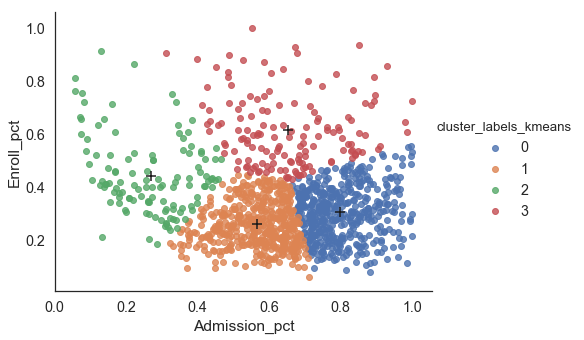

In [92]:
# Use K-mean n = 4 to cluster the data. Base on two variables: Enroll_pct, Admission_pct

kmeans_model = skc.KMeans(n_clusters=4)
kmeans_model.fit(df_ipeds[['Enroll_pct', 'Admission_pct']])
centroids = kmeans_model.cluster_centers_
centroids  # these are the centers of the clusters

# Plot the clusters with their centroids.
pd.options.mode.chained_assignment = None  # default='warn'
df_ipeds['cluster_labels_kmeans'] = kmeans_model.labels_
f = sns.lmplot(y='Enroll_pct', x='Admission_pct', data=df_ipeds, hue='cluster_labels_kmeans',
               fit_reg=False, height=5, aspect=1.3)
f.ax.scatter(centroids[:,1], centroids[:,0], marker='+', s=100,
             linewidths=2, color='k')  


## 3. Export the File for Tableau Use. 

In [93]:
# Do this ONLY when necessary. K-mean clusters labels change all the time. 
# export_csv = df_ipeds.to_csv (r'C:\Users\LC\605Python\df_ipeds_tableau.csv', index = None, header=True) #export to csv for Tableau

## 4. Regression Model
#### For details about the variables, see Tableau. 

In [94]:
# Regression 1:  
# Y: Desire.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)

import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ Normalized_SAT_ACT*Tuition_Out_State+ Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_private).fit() 
Private_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_private).fit() 
Public_interac_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ Normalized_SAT_ACT*Tuition_Out_State+ Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_public).fit() 
Public_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_public).fit() 
Combine_interac_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate+ Normalized_SAT_ACT*Tuition_Revised+ Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds).fit() 
Combine_desire_g = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate', data=df_ipeds).fit() 


df_R2adj_desire_g = pd.DataFrame({'Model': [ 'Private_interac_desire_g', 'Private_desire_g', 'Public_interac_desire_g', 'Public_desire_g', 'Combine_interac_desire_g', 'Combine_desire_g'], 
                   'R2_Adjusted': [Private_interac_desire_g.rsquared_adj,Private_desire_g.rsquared_adj, Public_interac_desire_g.rsquared_adj, Public_desire_g.rsquared_adj, Combine_interac_desire_g.rsquared_adj, Combine_desire_g.rsquared_adj]})
# df_R2adj_desire_g = pd.DataFrame({'Model': [ 'Private_desire_g',  'Public_desire_g',  'Combine_desire_g'], 
#                    'R2_Adjusted': [Private_desire_g.rsquared_adj, Public_desire_g.rsquared_adj, Combine_desire_g.rsquared_adj]})
df_R2adj_desire_g


,Model,R2_Adjusted
0,Private_interac_desire_g,0.418491
1,Private_desire_g,0.198470
2,Public_interac_desire_g,0.195309
3,Public_desire_g,0.038073
4,Combine_interac_desire_g,0.343458
5,Combine_desire_g,0.125537


In [95]:
# Regression 2:  
# Y: Chosen_pct.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)

import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_private).fit() 
Private_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_private).fit() 
Public_interac_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_public).fit() 
Public_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_public).fit() 
Combine_interac_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate + Normalized_SAT_ACT*Tuition_Revised + Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds).fit() 
Combine_chosen_g = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate', data=df_ipeds).fit() 

df_R2adj_chosen_g = pd.DataFrame({'Model': ['Private_interac_chosen_g', 'Private_chosen_g', 'Public_interac_chosen_g', 
                                          'Public_chosen_g', 'Combine_interac_chosen_g', 'Combine_chosen_g'], 
                   'R2_Adjusted': [Private_interac_chosen_g.rsquared_adj,Private_chosen_g.rsquared_adj, 
                              Public_interac_chosen_g.rsquared_adj, Public_chosen_g.rsquared_adj, 
                              Combine_interac_chosen_g.rsquared_adj, Combine_chosen_g.rsquared_adj]})
df_R2adj_chosen_g

,Model,R2_Adjusted
0,Private_interac_chosen_g,0.357850
1,Private_chosen_g,0.315362
2,Public_interac_chosen_g,0.195443
3,Public_chosen_g,0.148162
4,Combine_interac_chosen_g,0.312513
5,Combine_chosen_g,0.258036


In [96]:
# Regression 3:  
# Y: POT_applied.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)
import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_POT_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_private).fit() 
Private_POT_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_private).fit() 
Public_interac_POT_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds_public).fit() 
Public_POT_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate', data=df_ipeds_public).fit() 
Combine_POT_interac_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate + Normalized_SAT_ACT*Tuition_Revised + Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate', data=df_ipeds).fit() 
Combine_POT_applied_g = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate', data=df_ipeds).fit() 

df_R2adj_POT_applied_g = pd.DataFrame({'Model': ['Private_interac_POT_applied_g', 'Private_POT_applied_g', 'Public_interac_POT_applied_g', 
                                          'Public_POT_applied_g', 'Combine_POT_interac_applied_g', 'Combine_POT_applied_g',], 
                   'R2_Adjusted': [Private_interac_POT_applied_g.rsquared_adj,Private_POT_applied_g.rsquared_adj, 
                              Public_interac_POT_applied_g.rsquared_adj, Public_POT_applied_g.rsquared_adj, 
                              Combine_POT_interac_applied_g.rsquared_adj, Combine_POT_applied_g.rsquared_adj]})
df_R2adj_POT_applied_g

,Model,R2_Adjusted
0,Private_interac_POT_applied_g,0.348335
1,Private_POT_applied_g,0.288010
2,Public_interac_POT_applied_g,0.511412
3,Public_POT_applied_g,0.420176
4,Combine_POT_interac_applied_g,0.397112
5,Combine_POT_applied_g,0.315208


In [97]:
# Regression 4:  
# Y: Desire.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate, cluster
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)

import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ Normalized_SAT_ACT*Tuition_Out_State+ Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate + cluster_labels_kmeans', data=df_ipeds_private).fit() 
Private_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + cluster_labels_kmeans', data=df_ipeds_private).fit() 
Public_interac_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ Normalized_SAT_ACT*Tuition_Out_State+ Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate + cluster_labels_kmeans', data=df_ipeds_public).fit() 
Public_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + cluster_labels_kmeans', data=df_ipeds_public).fit() 
Combine_interac_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate+ Normalized_SAT_ACT*Tuition_Revised+ Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate + cluster_labels_kmeans', data=df_ipeds).fit() 
Combine_desire_gc = smf.ols(formula='Desire ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate + cluster_labels_kmeans', data=df_ipeds).fit() 


df_R2adj_desire_gc = pd.DataFrame({'Model': [ 'Private_interac_desire_gc', 'Private_desire_gc', 'Public_interac_desire_gc', 'Public_desire_gc', 'Combine_interac_desire_gc', 'Combine_desire_gc'], 
                   'R2_Adjusted': [Private_interac_desire_gc.rsquared_adj,Private_desire_gc.rsquared_adj, Public_interac_desire_gc.rsquared_adj, Public_desire_gc.rsquared_adj, Combine_interac_desire_gc.rsquared_adj, Combine_desire_gc.rsquared_adj]})
# df_R2adj_desire_g = pd.DataFrame({'Model': [ 'Private_desire_g',  'Public_desire_g',  'Combine_desire_g'], 
#                    'R2_Adjusted': [Private_desire_g.rsquared_adj, Public_desire_g.rsquared_adj, Combine_desire_g.rsquared_adj]})
df_R2adj_desire_gc


,Model,R2_Adjusted
0,Private_interac_desire_gc,0.439304
1,Private_desire_gc,0.273618
2,Public_interac_desire_gc,0.492648
3,Public_desire_gc,0.432106
4,Combine_interac_desire_gc,0.384928
5,Combine_desire_gc,0.232334


In [98]:
# Regression 5:  
# Y: Chosen_pct.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate, cluster
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)

import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate + C(cluster_labels_kmeans)', data=df_ipeds_private).fit() 
Private_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + C(cluster_labels_kmeans)', data=df_ipeds_private).fit() 
Public_interac_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate + C(cluster_labels_kmeans)', data=df_ipeds_public).fit() 
Public_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds_public).fit() 
Combine_interac_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate + Normalized_SAT_ACT*Tuition_Revised + Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds).fit() 
Combine_chosen_gc = smf.ols(formula='Chosen_pct ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds).fit() 

df_R2adj_chosen_gc = pd.DataFrame({'Model': ['Private_interac_chosen_gc', 'Private_chosen_gc', 'Public_interac_chosen_gc', 
                                          'Public_chosen_gc', 'Combine_interac_chosen_gc', 'Combine_chosen_gc'], 
                   'R2_Adjusted': [Private_interac_chosen_gc.rsquared_adj,Private_chosen_gc.rsquared_adj, 
                              Public_interac_chosen_gc.rsquared_adj, Public_chosen_gc.rsquared_adj, 
                              Combine_interac_chosen_gc.rsquared_adj, Combine_chosen_gc.rsquared_adj]})
df_R2adj_chosen_gc
# Private_interac_chosen_gc.summary()

,Model,R2_Adjusted
0,Private_interac_chosen_gc,0.636186
1,Private_chosen_gc,0.619605
2,Public_interac_chosen_gc,0.568344
3,Public_chosen_gc,0.568358
4,Combine_interac_chosen_gc,0.624321
5,Combine_chosen_gc,0.613863


In [99]:
# Regression 6:  
# Y: POT_Applied.
# X: Normalized_SAT_ACT, Tuition_Out_State OR Tuition_Revised, grad_rate, cluster
# Data Frame: varies. Public only / Private only / Combined

df_ipeds.dropna(subset=['grad_rate'], inplace = True)
import statsmodels.formula.api as smf

df_ipeds_private=df_ipeds[(df_ipeds.Control_of_institution == "Private not-for-profit") ]
df_ipeds_public=df_ipeds[(df_ipeds.Control_of_institution == "Public") ]

Private_interac_POT_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate + C(cluster_labels_kmeans)', data=df_ipeds_private).fit() 
Private_POT_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds_private).fit() 
Public_interac_POT_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate + Normalized_SAT_ACT*Tuition_Out_State + Tuition_Out_State*grad_rate + Normalized_SAT_ACT*grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds_public).fit() 
Public_POT_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Out_State + grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds_public).fit() 
Combine_POT_interac_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate + Normalized_SAT_ACT*Tuition_Revised + Tuition_Revised*grad_rate + Normalized_SAT_ACT*grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds).fit() 
Combine_POT_applied_gc = smf.ols(formula='POT_applied ~ Normalized_SAT_ACT + Tuition_Revised + grad_rate+ C(cluster_labels_kmeans)', data=df_ipeds).fit() 

df_R2adj_POT_applied_gc = pd.DataFrame({'Model': ['Private_interac_POT_applied_gc', 'Private_POT_applied_gc', 'Public_interac_POT_applied_gc', 
                                          'Public_POT_applied_gc', 'Combine_POT_interac_applied_gc', 'Combine_POT_applied_gc',], 
                   'R2_Adjusted': [Private_interac_POT_applied_gc.rsquared_adj,Private_POT_applied_gc.rsquared_adj, 
                              Public_interac_POT_applied_gc.rsquared_adj, Public_POT_applied_gc.rsquared_adj, 
                              Combine_POT_interac_applied_gc.rsquared_adj, Combine_POT_applied_gc.rsquared_adj]})
df_R2adj_POT_applied_gc

,Model,R2_Adjusted
0,Private_interac_POT_applied_gc,0.355206
1,Private_POT_applied_gc,0.317298
2,Public_interac_POT_applied_gc,0.542381
3,Public_POT_applied_gc,0.486589
4,Combine_POT_interac_applied_gc,0.421594
5,Combine_POT_applied_gc,0.366233


#### For regression result conclustion and limitation, see Tableau. 



## 5. Apply Classification Technique

In [100]:
# Prepare dataframe for train/test

# Note: Why use the 'Tuition_Out_State' instead of other tuition variables? 
# Because the Tuition_Out_State is a fair measure of the college's attraction to all the out-of-state students. 

ipeds_tuition_score_ori = df_ipeds[['Tuition_Out_State', 'Normalized_SAT_ACT', 'Control_of_institution']].copy()
ipeds_tuition_score_ori
ipeds_tuition_score=ipeds_tuition_score_ori.drop([ 'Control_of_institution'], axis=1)

ipeds_tuition_score_raw = ipeds_tuition_score.columns

In [101]:
# Split data to train/test with Tuition_Out_State and Normalized_SAT_ACT

# ipeds_tuition_score_ori = df_ipeds[['Tuition_Revised', 'Normalized_SAT_ACT', 'Control_of_institution']].copy()
from sklearn.model_selection import train_test_split
X_cols =['Tuition_Out_State','Normalized_SAT_ACT' ]
# X_cols
y=ipeds_tuition_score_ori['Control_of_institution']

f_train, f_test, l_train, l_test = train_test_split(ipeds_tuition_score_ori[ipeds_tuition_score_raw], 
                 ipeds_tuition_score_ori['Control_of_institution'], test_size=0.4, random_state=42)


Text(0.5, 1.0, 'K-Nearest Neighbors')

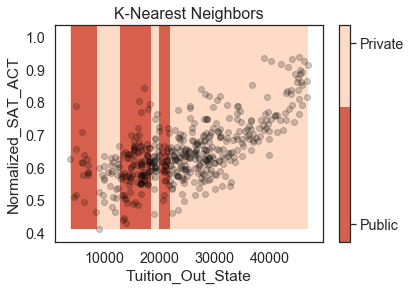

In [102]:
# Use K-Nearest Method and Plot

n = 2
ipeds_neigh = KNeighborsClassifier(n_neighbors=n) #using k-Nearest method
ipeds_neigh.fit(ipeds_tuition_score_ori[['Tuition_Out_State','Normalized_SAT_ACT']],ipeds_tuition_score_ori['Control_of_institution'])


# Plot the result (K-Nearest)

def plot_scores(df, classifier): 
    xx,yy=np.meshgrid(np.linspace(df['Tuition_Out_State'].min(),df['Tuition_Out_State'].max()+10), 
                      np.linspace(df['Normalized_SAT_ACT'].min(),df['Normalized_SAT_ACT'].max()+0.1), 
                     )  
    #df['Normalized SAT'].min(),df['Normalized SAT'].max()+4
    Zstring = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    repdict = {'Public' : 1, 'Private not-for-profit' : 2
              } #map predictions to plottable numbers

    Z = np.zeros_like(Zstring)
    for k,v in repdict.items():
        Z[Zstring==k]=v
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('RdBu',6),vmin=0,vmax=5)
    plt.xlabel('Tuition_Out_State');plt.ylabel('Normalized_SAT_ACT')
    cbar = plt.colorbar(ticks=[1,2])
    cbar.ax.set_yticklabels(['Public', 'Private'])
    plt.scatter(df['Tuition_Out_State'],df['Normalized_SAT_ACT'], color="black",alpha=0.2) 
    
plot_scores(f_test,ipeds_neigh)
plt.title('K-Nearest Neighbors', fontsize = 16)

Text(0.5, 1.0, 'Naive Bayes')

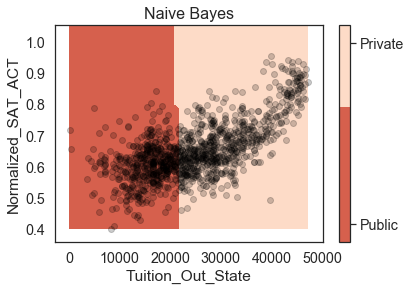

In [103]:
# Use Naive Bays Method and Plot

from sklearn.naive_bayes import GaussianNB  

ipeds_gnb = GaussianNB().fit(f_train,l_train)
ipeds_gnb_predictions_test = ipeds_gnb.predict(f_test)

# Plot the result (Naive Bays)
plot_scores(ipeds_tuition_score,ipeds_gnb)
plt.title('Naive Bayes', fontsize = 16)

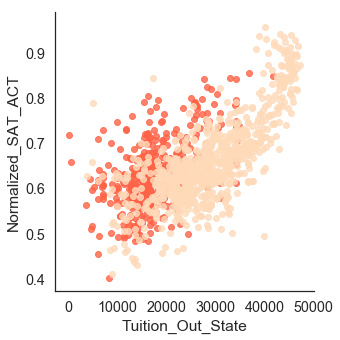

In [104]:
# This is just to show the actual data - Scatter plot. Color by Public/Private
sns.lmplot(y='Normalized_SAT_ACT', x='Tuition_Out_State', hue='Control_of_institution', 
           palette = {'Public':'tomato', 'Private not-for-profit':'peachpuff'}, legend = False,
           fit_reg=False, data=df_ipeds);
# plt.title('Normalized_SAT_ACT vs. Tuition_Out_State')


#### For comments on the classification result, refer to Tableau. 

# Thank you